In [3]:
#%pip install -q -U --no-warn-conflicts malariagen_data
#%pip install -q --no-warn-conflicts petl

In [4]:
import malariagen_data
import allel
import numpy as np
import numba
from numba import njit
import pandas as pd
import functools
#import dask
from dask.diagnostics.progress import ProgressBar
#dask.config.set(**{'array.slicing.split_large_chunks': True})
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.legend import Legend
#import matplotlib_venn as venn
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [5]:
import scipy
import scipy.cluster
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy

In [6]:
#Mounting Google Drive
import os
#from google.colab import drive
#drive.mount("drive")

# make dir
results_dir = '/home/mkient/Desktop/IR/'
os.makedirs(results_dir, exist_ok=True)
os.chdir(results_dir)
#os.listdir()

In [7]:
## Importing malariagen data set
ag3 = malariagen_data.Ag3("gs://vo_agam_release_master_us_central1/", pre=True)
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release_master_us_central1/
Data releases available : 3.0, 3.1, 3.10, 3.11, 3.12, 3.13, 3.14, 3.15, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9
Results cache           : None
Cohorts analysis        : 20250502
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 13.0.0
Client location         : Centre, Burkina Faso
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v13.0.0/Ag3.html

In [8]:
df_samples=ag3.sample_metadata(sample_sets='3.11', sample_query='country=="Burkina Faso"')
sets = list(df_samples.sample_set.unique())

In [9]:
## transcrit and region
region = "2L:2358158-2431617"
transcript = 'AGAP004707-RD'

#To access to the genotypes within the 3L chromosomes
ds_snps = ag3.snp_calls(region="2L:2358158-2431617", sample_sets=sets)

# Take some SNP in the X chromosomes
ds_pos = allel.SortedIndex(ds_snps['variant_position'].values)

# To filter the SNP dataset and warp the dataset to GT array
filt = 'gamb_colu_arab'
filt_val = ds_snps[f"variant_filter_pass_{filt}"].values

## Compute genotype & count the number of alleles
with ProgressBar():
  ds_gt = allel.GenotypeArray(ds_snps["call_genotype"][filt_val].data)
  ds_ac = ds_gt.count_alleles()

[########################################] | 100% Completed | 13.98 s


## Diplotype clustering

In [10]:
diplo_d = ag3.diplotype_pairwise_distances(region=region,sample_query='country=="Burkina Faso"',
                                           sample_sets=sets, site_mask='gamb_colu_arab',
                                           distance_metric='euclidean')

Load genotypes for distance calculation:   0%|          | 0/116 [00:00<?, ?it/s]

In [11]:
method='complete'
y = np.asarray(diplo_d[0], order='c', dtype=np.double)
n = int(distance.num_obs_y(diplo_d[0]))
method = dict(single=0, complete=1)[method]
z_clust1 = scipy.cluster.hierarchy.linkage(y, method='complete')

In [12]:
z_clust = scipy.cluster.hierarchy.linkage(diplo_d[0], method='complete')

In [13]:
from scipy.cluster.hierarchy import dendrogram, fcluster, leaves_list, set_link_color_palette

In [14]:
#fcluster(z_clust1, t=0.1, criterion='distance')

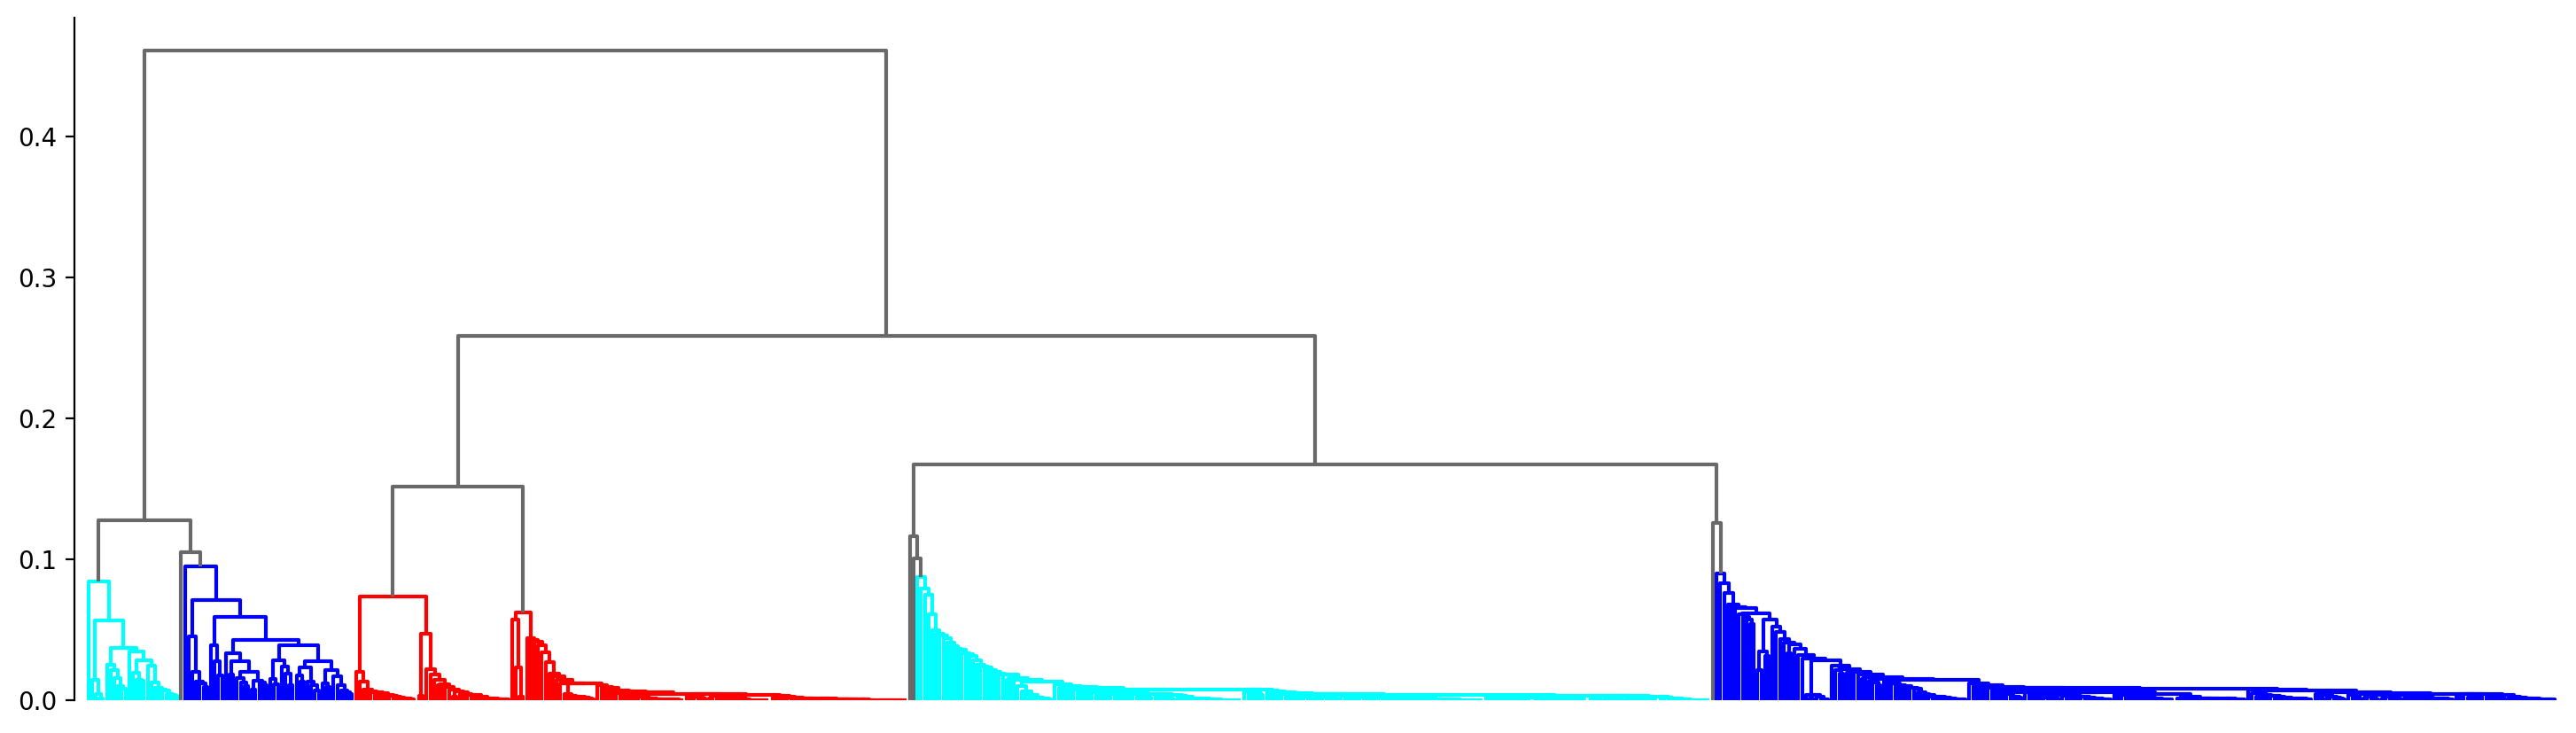

In [15]:
fig, ax = plt.subplots(figsize=(18, 5))
set_link_color_palette(['cyan','blue','red','red'])
sns.despine(ax=ax, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust1, count_sort=True, ax=ax, color_threshold=0.1, no_labels=True,
                                          above_threshold_color='dimgrey')

### samples handling, heterozygoty and SNP freq

In [16]:
leaves = dend['leaves']
leaf_data = df_samples.copy().iloc[leaves]
leaf_data['pop_location'] = [z+', '+y for z, y in zip(leaf_data.location, leaf_data.aim_species)]
leaf_list = list(leaf_data['sample_id'])
color_l = dend['leaves_color_list']

leaf_y, n_leaves = 0, len(leaves)
leaf_data['dx'] = np.arange(n_leaves)
leaf_data['dy'] = np.repeat(leaf_y, n_leaves)
leaf_data['dy1'] = np.repeat(0.5, n_leaves)
#leaf_data['dy2'] = np.repeat(leaf_y-0.2, n_leaves)
#leaf_data['dy12'] = np.repeat(-0.01, n_leaves)
pop_ids = list(leaf_data.aim_species.unique())
colored, pop_colors = sns.color_palette("husl", len(pop_ids)), {}
for i in range(len(pop_ids)):
    pop_colors[pop_ids[i]] = colored[i]

In [17]:
het_per_sample = ds_gt.take(leaves).is_het().sum(axis=0) / ds_gt.take(leaves).is_called().sum(axis=0)
df_het = pd.DataFrame({'sample_id': leaf_list, 'heterozigosity': het_per_sample}).set_index('sample_id')
df_het = df_het.loc[leaf_data['sample_id'].to_list(), :].T

In [18]:
df_snps1 = ag3.snp_genotype_allele_counts(transcript=transcript,sample_sets=sets, site_mask='gamb_colu_arab')
df_snps2 = df_snps1.query("effect == ['NON_SYNONYMOUS_CODING', 'START_LOST', 'STOP_LOST', 'STOP_GAINED']")
df_snps3 = df_snps2.set_index('label')
df_snps4 = df_snps3.filter(like='count_').loc[:,['count_'+ s for s in leaf_list]]
df_snps5 = df_snps4.assign(af=lambda x: x.sum(axis=1) / (x.shape[1] * 2))
dfs_snps = df_snps5.drop(columns="af")

lst_gf = ['2L:2,391,228 G>T (V402L)','2L:2,416,980 C>T (T791M)','2L:2,422,652 A>T (L995F)',
          '2L:2,429,617 T>C (I1527T)','2L:2,429,896 G>C (E1597Q)','2L:2,430,880 C>T (P1874S)',
          '2L:2,430,881 C>T (P1874L)','2L:2,422,651 T>C (L995S)']
dfs_snps = dfs_snps.loc[lst_gf]

Load SNP genotypes:   0%|          | 0/56 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/209001 [00:00<?, ?it/s]

### Plot clustering

In [19]:
## Costum colors
legend_tips = {'gambiae':["o",0,'darkred'],'coluzzii':["X",1,'magenta'],'arabiensis':["D",2,'navy'],
               'intermediate_gambcolu_arabiensis':['v',3,'darkgoldenrod'],'intermediate_gambiae_coluzzii':['v',3,'darkgoldenrod']}
sp_col = ['darkred','magenta','navy','darkgoldenrod']
ag_dict = {'gambiae':'An. gambiae s.s.','coluzzii':'An. coluzzii','arabiensis':'An. arabiensis',
           'intermediate_gambcolu_arabiensis':'hybrid'}
leg_values = [legend_tips[i][1] for i in leaf_data.aim_species]
leg_labels = ['An. gambiae s.s.', 'An. coluzzii', 'An. arabiensis', 'hybrid']
color_maps = mpl.colors.ListedColormap([legend_tips[i][2] for i in list(legend_tips.keys())[:-1]])

In [20]:
#plt.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
#plt.xlim(0,n_leaves)
#plt.axis('off')

In [21]:
#haplo_maps

In [22]:
#sns.light_palette("indigo", as_cmap=True)

<Axes: xlabel='sample_id'>

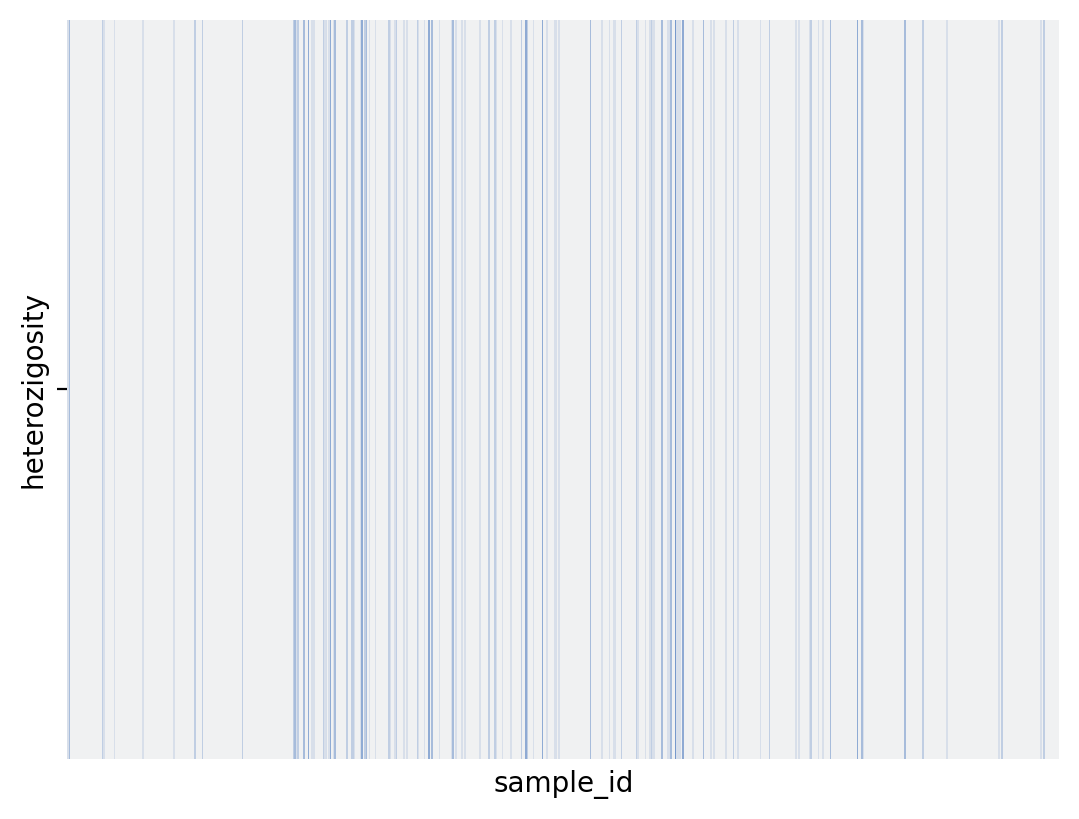

In [23]:
sns.heatmap(data=df_het, vmin=df_het.iloc[0,:].min(), vmax=df_het.iloc[0,:].max(),
            cmap=sns.light_palette("#79C", as_cmap=True), xticklabels=[], cbar=False)


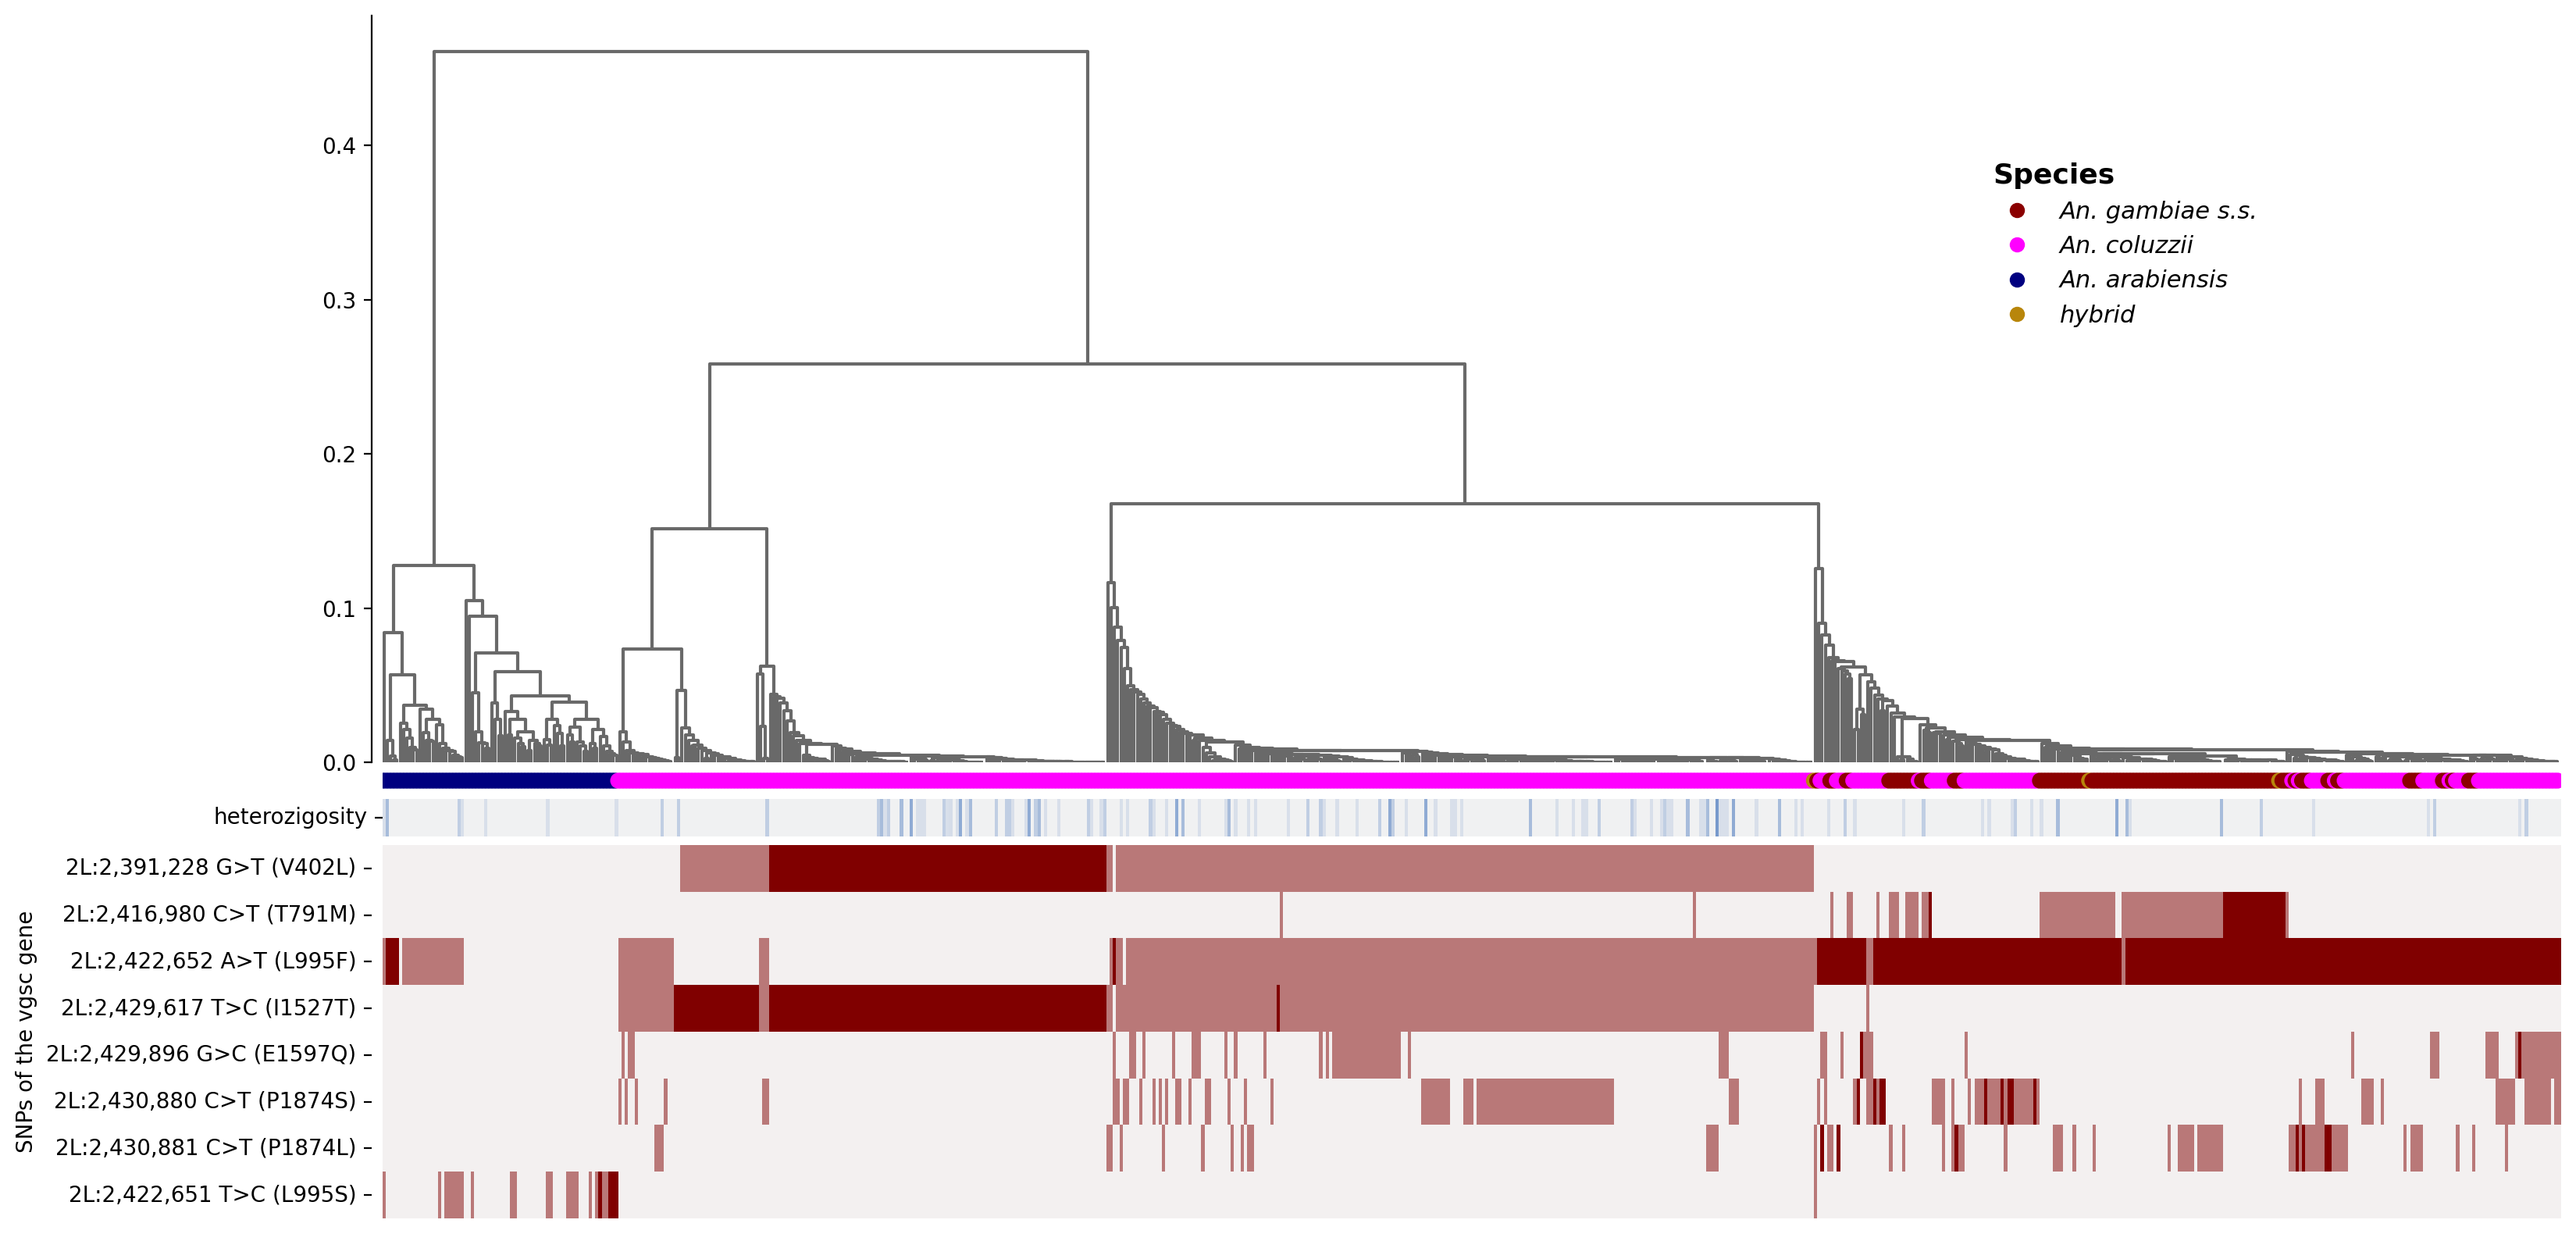

In [24]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                          above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax2=sns.heatmap(data=df_het, vmin=df_het.iloc[0,:].min(), vmax=df_het.iloc[0,:].max(), cmap=sns.light_palette("#79C", as_cmap=True), xticklabels=[], cbar=False)
ax2.set(xlabel=' ', ylabel=' ')
plt.yticks(rotation=0)

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("maroon", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.8),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')


plt.show()
fig.savefig(fname='VGSC/save_fig/clust_fig.png',dpi=300, bbox_inches='tight')

### Haplotypes samples selection

In [25]:
dfs_snps_T = dfs_snps.T
#dfs_snps_T

In [26]:
## Haplotypes selections
L995FxL995F = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 2 and `2L:2,391,228 G>T (V402L)` == 0 and `2L:2,429,617 T>C (I1527T)` == 0").index.to_list()
L995FxV402LxI1527T = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 1 and `2L:2,391,228 G>T (V402L)` == 1 and `2L:2,429,617 T>C (I1527T)` == 1").index.to_list()
V402LxI1527T = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 0 and `2L:2,391,228 G>T (V402L)` == 2 and `2L:2,429,617 T>C (I1527T)` == 2").index.to_list()
list_I1527T_htz1 = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 0 and `2L:2,391,228 G>T (V402L)` == 1 and `2L:2,429,617 T>C (I1527T)` == 2").index.to_list()
list_I1527T_htz2 = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 1 and `2L:2,391,228 G>T (V402L)` == 0 and `2L:2,429,617 T>C (I1527T)` == 1").index.to_list()
L995FxV402LxI1527T_htz = list_I1527T_htz1 + list_I1527T_htz2
LVI = dfs_snps_T.query("`2L:2,422,652 A>T (L995F)` == 0 and `2L:2,391,228 G>T (V402L)` == 0 and `2L:2,429,617 T>C (I1527T)` == 0").index.to_list()
other_haps = [i for i in dfs_snps_T.index.to_list() if i not in L995FxL995F+L995FxV402LxI1527T+V402LxI1527T+LVI]

haplo = {
    'FF': L995FxL995F,
    'FLT': L995FxV402LxI1527T,
    'LT': V402LxI1527T,
    'wt': LVI,
    'other': other_haps
}

haplo_sample_id = {
    'FF': [i.split('count_')[1] for i in L995FxL995F],
    'FLT': [i.split('count_')[1] for i in L995FxV402LxI1527T],
    'LT': [i.split('count_')[1] for i in V402LxI1527T],
    'wt': [i.split('count_')[1] for i in LVI],
    'other': [i.split('count_')[1] for i in other_haps]
}

In [27]:
L995F_haplo0 = dfs_snps.loc[:,dfs_snps.loc['2L:2,422,652 A>T (L995F)',:]==0]
L995F_hap0_samples = [i.split('count_')[1] for i in L995F_haplo0.columns.to_list()]
L995F_haplo1 = dfs_snps.loc[:,dfs_snps.loc['2L:2,422,652 A>T (L995F)',:]==1]
L995F_hap1_samples = [i.split('count_')[1] for i in L995F_haplo1.columns.to_list()]
L995F_haplo2 = dfs_snps.loc[:,dfs_snps.loc['2L:2,422,652 A>T (L995F)',:]==2]
L995F_hap2_samples = [i.split('count_')[1] for i in L995F_haplo2.columns.to_list()]

In [28]:
haplo_dict = {'L995F_hap0_samples':L995F_hap0_samples,
              'L995F_hap1_samples':L995F_hap1_samples,
              'L995F_hap2_samples':L995F_hap2_samples}

In [29]:
haplo_dict.keys()

dict_keys(['L995F_hap0_samples', 'L995F_hap1_samples', 'L995F_hap2_samples'])

In [30]:
haplo_dict.keys()
#np.save('VGSC/data/haplo_dict.npy', haplo_dict)
#np.save('VGSC/data/haplo_sample_id.npy', haplo_sample_id)

dict_keys(['L995F_hap0_samples', 'L995F_hap1_samples', 'L995F_hap2_samples'])

# Compute PCA

In [31]:
map_dict = {}
for hap in haplo_sample_id.keys():
  hap_i = haplo_sample_id[hap]
  for sample_id in hap_i:
    map_dict[sample_id] = hap
len(map_dict.keys())
df_samples['haplo_id'] = df_samples.sample_id.map(map_dict)

hap_labels = {
    'FF': 'Homozygotes L995F',
    'other': 'Other diplotypes',
    'FLT': 'Heterozygotes L995F-V402L-I1527T',
    'LT':'Homozygotes V402L-I1527T',
    'wt': 'Wild type'
}

haplo_source = list(haplo_sample_id.keys())
haplo_col = sns.color_palette(n_colors=len(hap_labels.keys()))
leaf_data['haplo_id'] = leaf_data.sample_id.map(map_dict)
leaf_data['haplo_label'] = leaf_data.haplo_id.map(hap_labels)

haplo_tips = {
    'Homozygotes L995F':["D",0,haplo_col[0]],
    'Other diplotypes':["D",1,haplo_col[1]],
    'Heterozygotes L995F-V402L-I1527T':["D",2,haplo_col[2]],
    'Homozygotes V402L-I1527T':["D",3,haplo_col[3]],
    'Wild type':["D",4,haplo_col[4]]
}

haplo_values = [haplo_tips[i][1] for i in leaf_data.haplo_label]
haplo_labels = ['Homozygotes L995F', 'Other diplotypes', 'Heterozygotes L995F-V402L-I1527T',
                'Homozygotes V402L-I1527T','Wild type']

hap_color = [haplo_tips[i][2] for i in leaf_data.haplo_label]
haplo_maps = mpl.colors.ListedColormap([haplo_tips[i][2] for i in list(haplo_tips.keys())[:-1]])

## Create cluster groups based on diplotypes indexes
results,current_grp, interval,indexes, hapidx = [], [], [], [], []
for idx,vals in enumerate(haplo_values):
  if not current_grp or current_grp[-1] == vals:
    current_grp.append(vals)
    indexes.append(idx)
    hapidx.append(leaves_list(z_clust)[idx])
  else:
    results.append(hapidx)
    interval.append((indexes[0],indexes[-1]))
    current_grp = [vals]
    indexes = [idx]
    hapidx = [leaves_list(z_clust)[idx]]
if current_grp:
  results.append(hapidx)
  interval.append((indexes[0],indexes[-1]))

#select vspans
vspans = []
for i in results:
  if len(i) > 10:
    vspans.append(interval[results.index(i)])
#vspans

In [32]:
#vspans

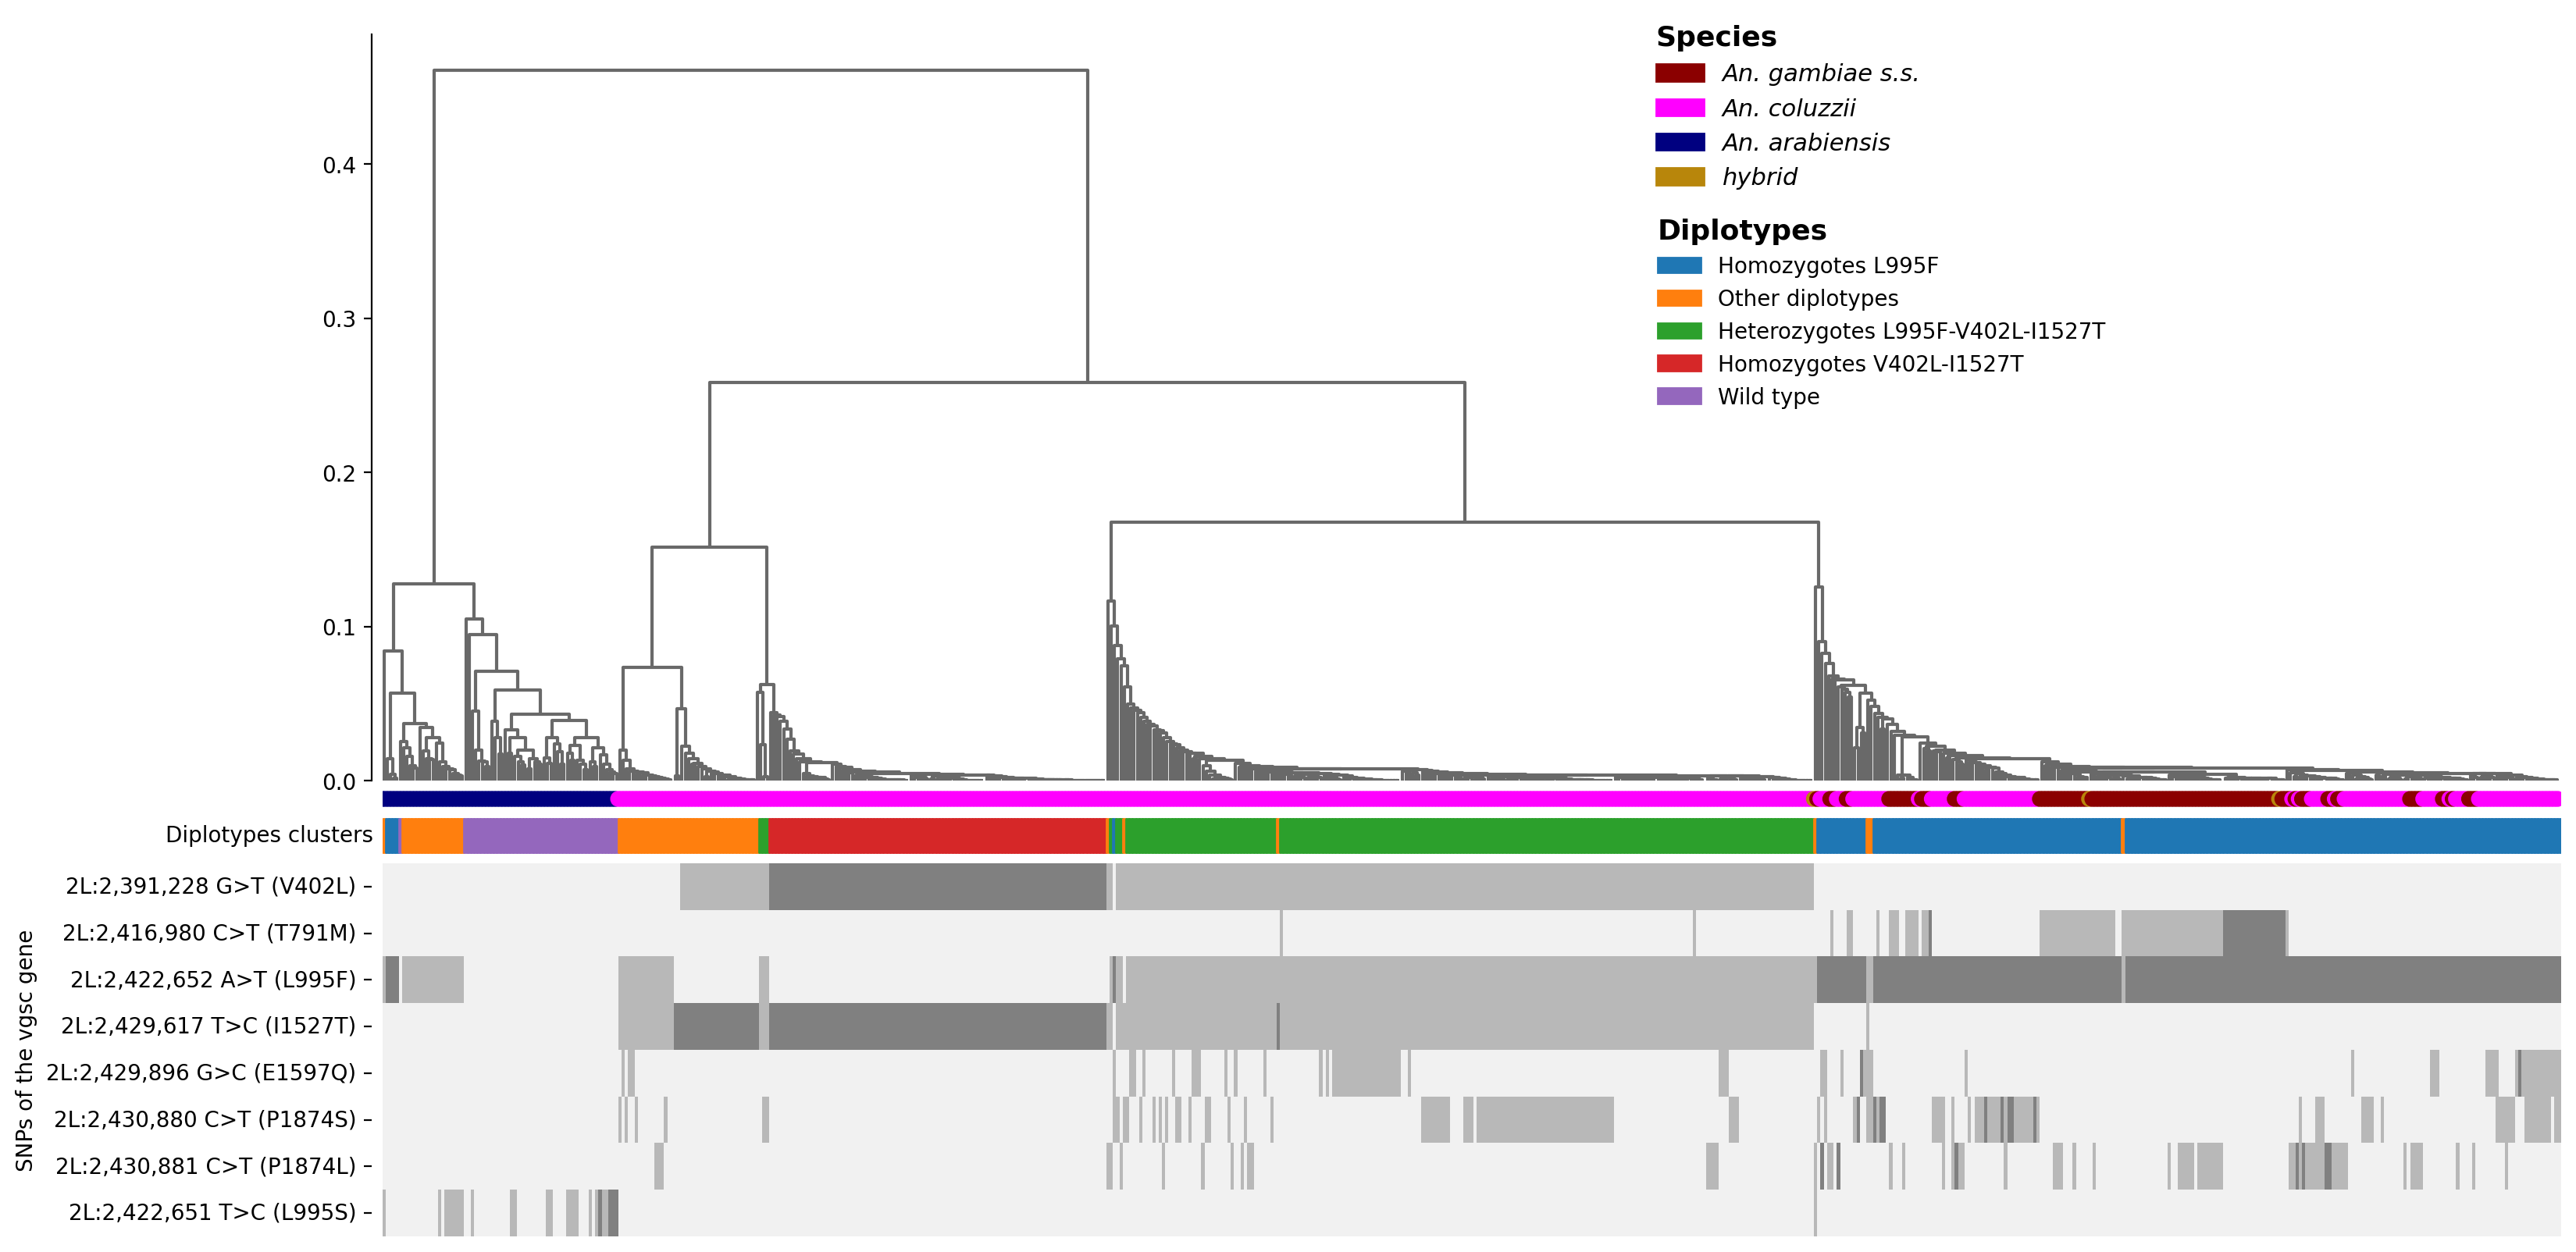

In [33]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Diplotypes clusters',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',
              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.8, 0.78),frameon=False)
ax0.add_artist(aleg)

plt.show()
#fig.savefig(fname='VGSC/save_fig/clust_fig1.png',dpi=300, bbox_inches='tight')

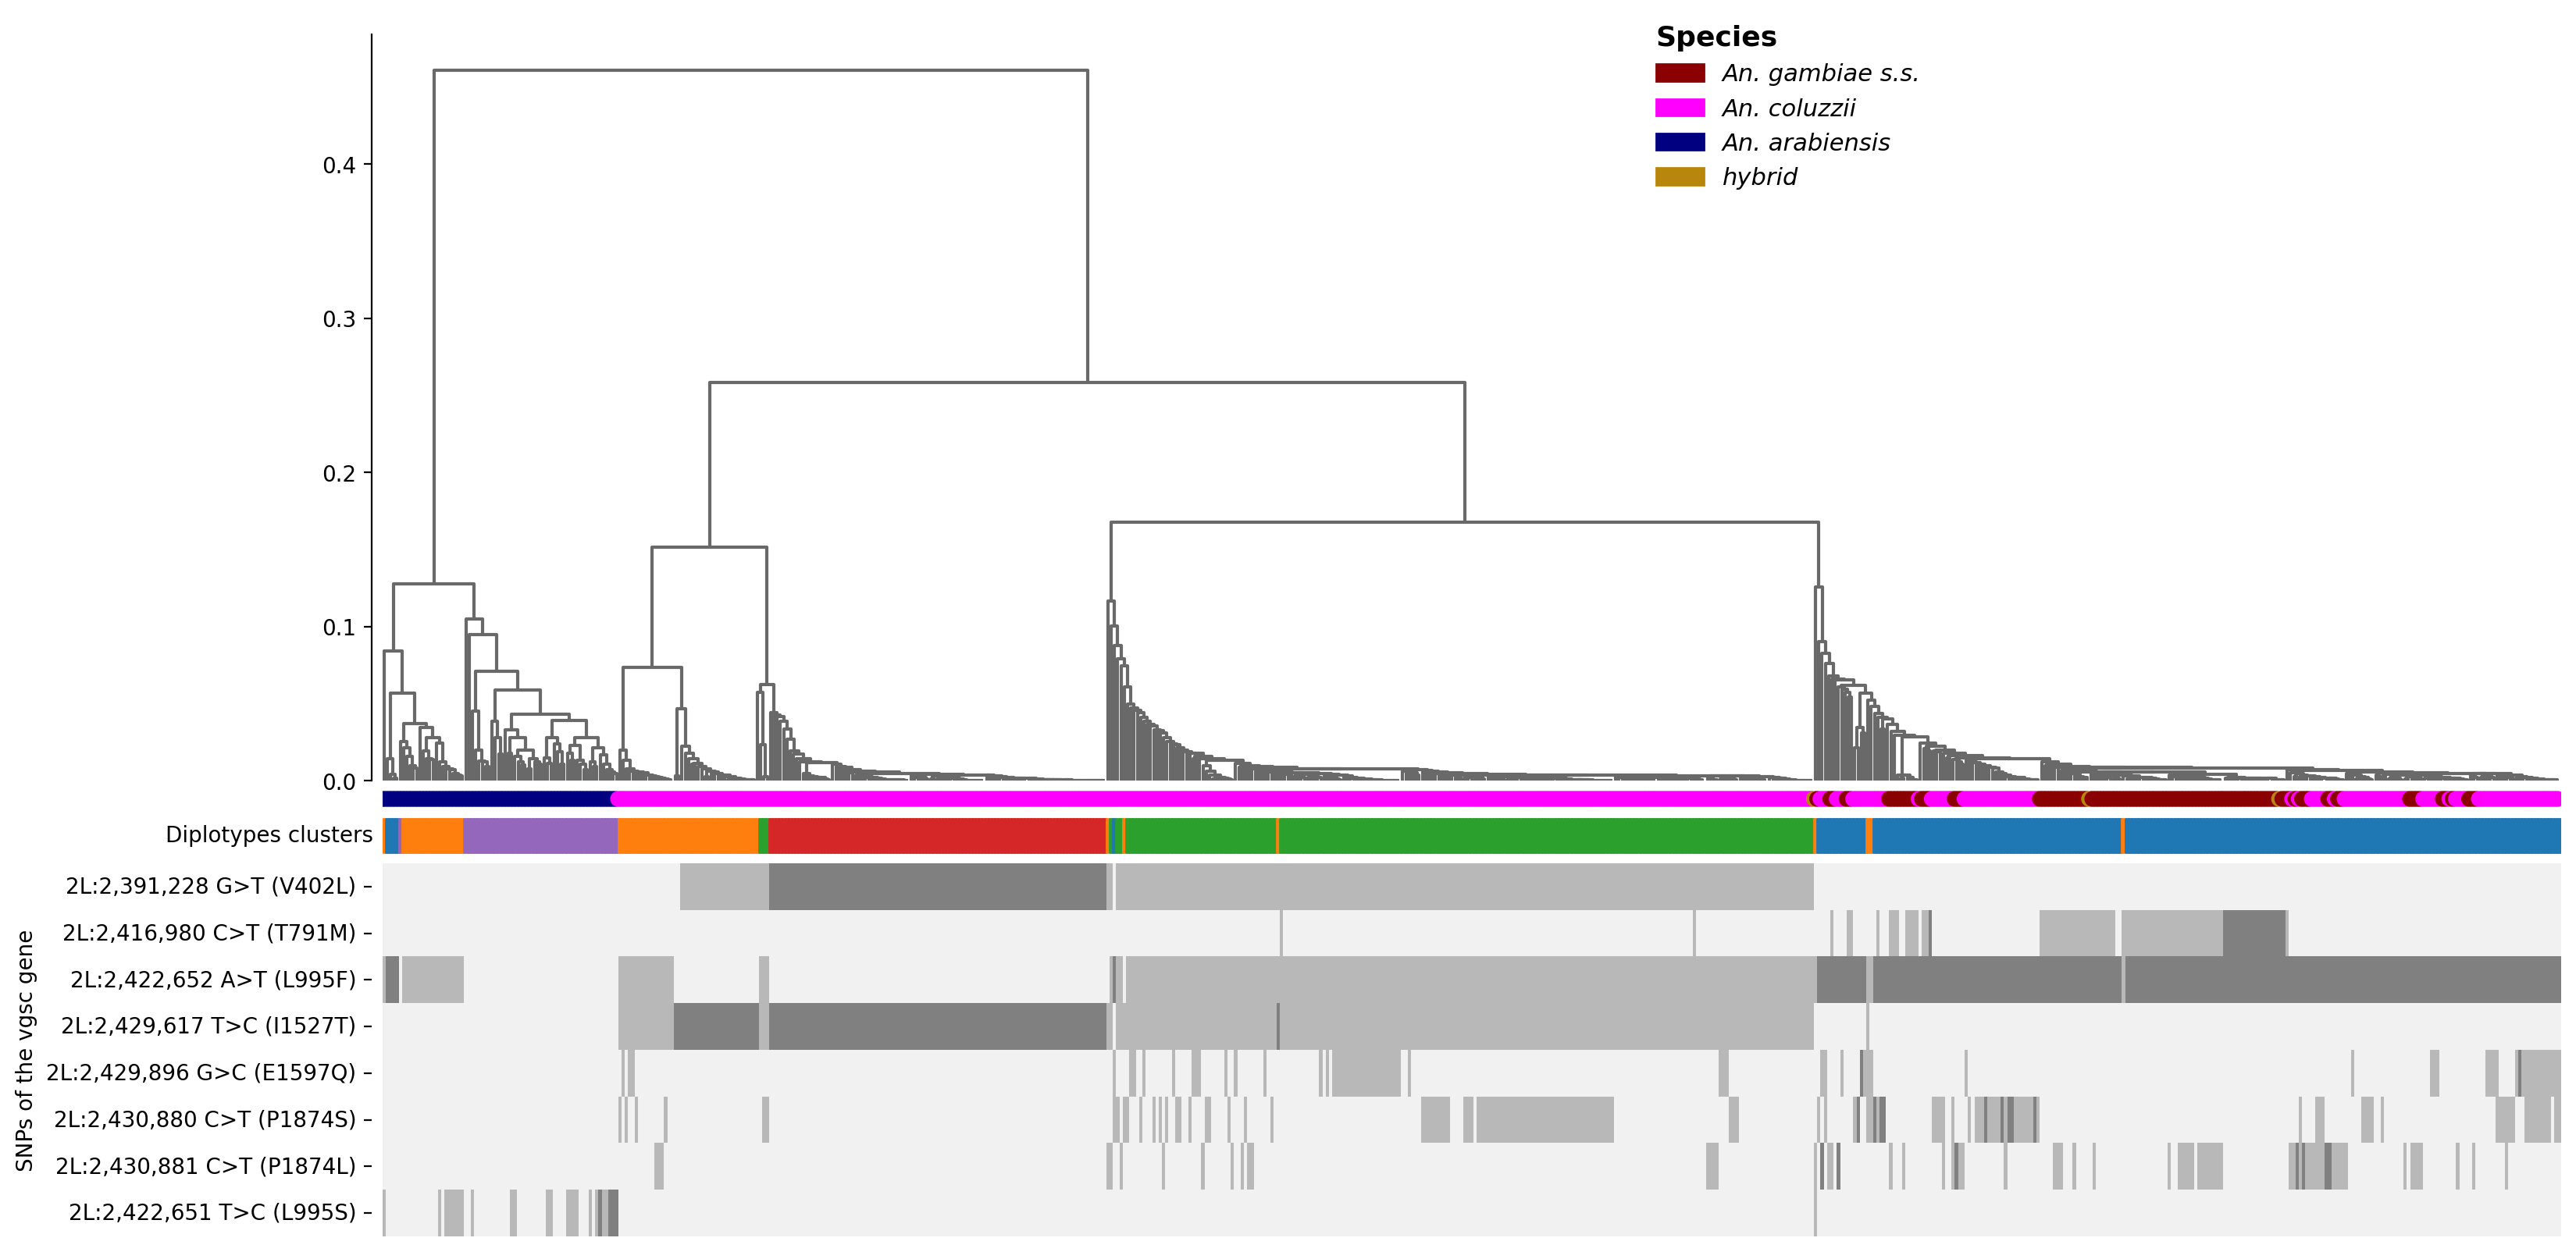

In [34]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(4, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Diplotypes clusters',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
#handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
#aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',
#              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.8, 0.78),frameon=False)
#ax0.add_artist(aleg)

plt.show()
#fig.savefig(fname='VGSC/save_fig/clust_fig12.png',dpi=300, bbox_inches='tight')

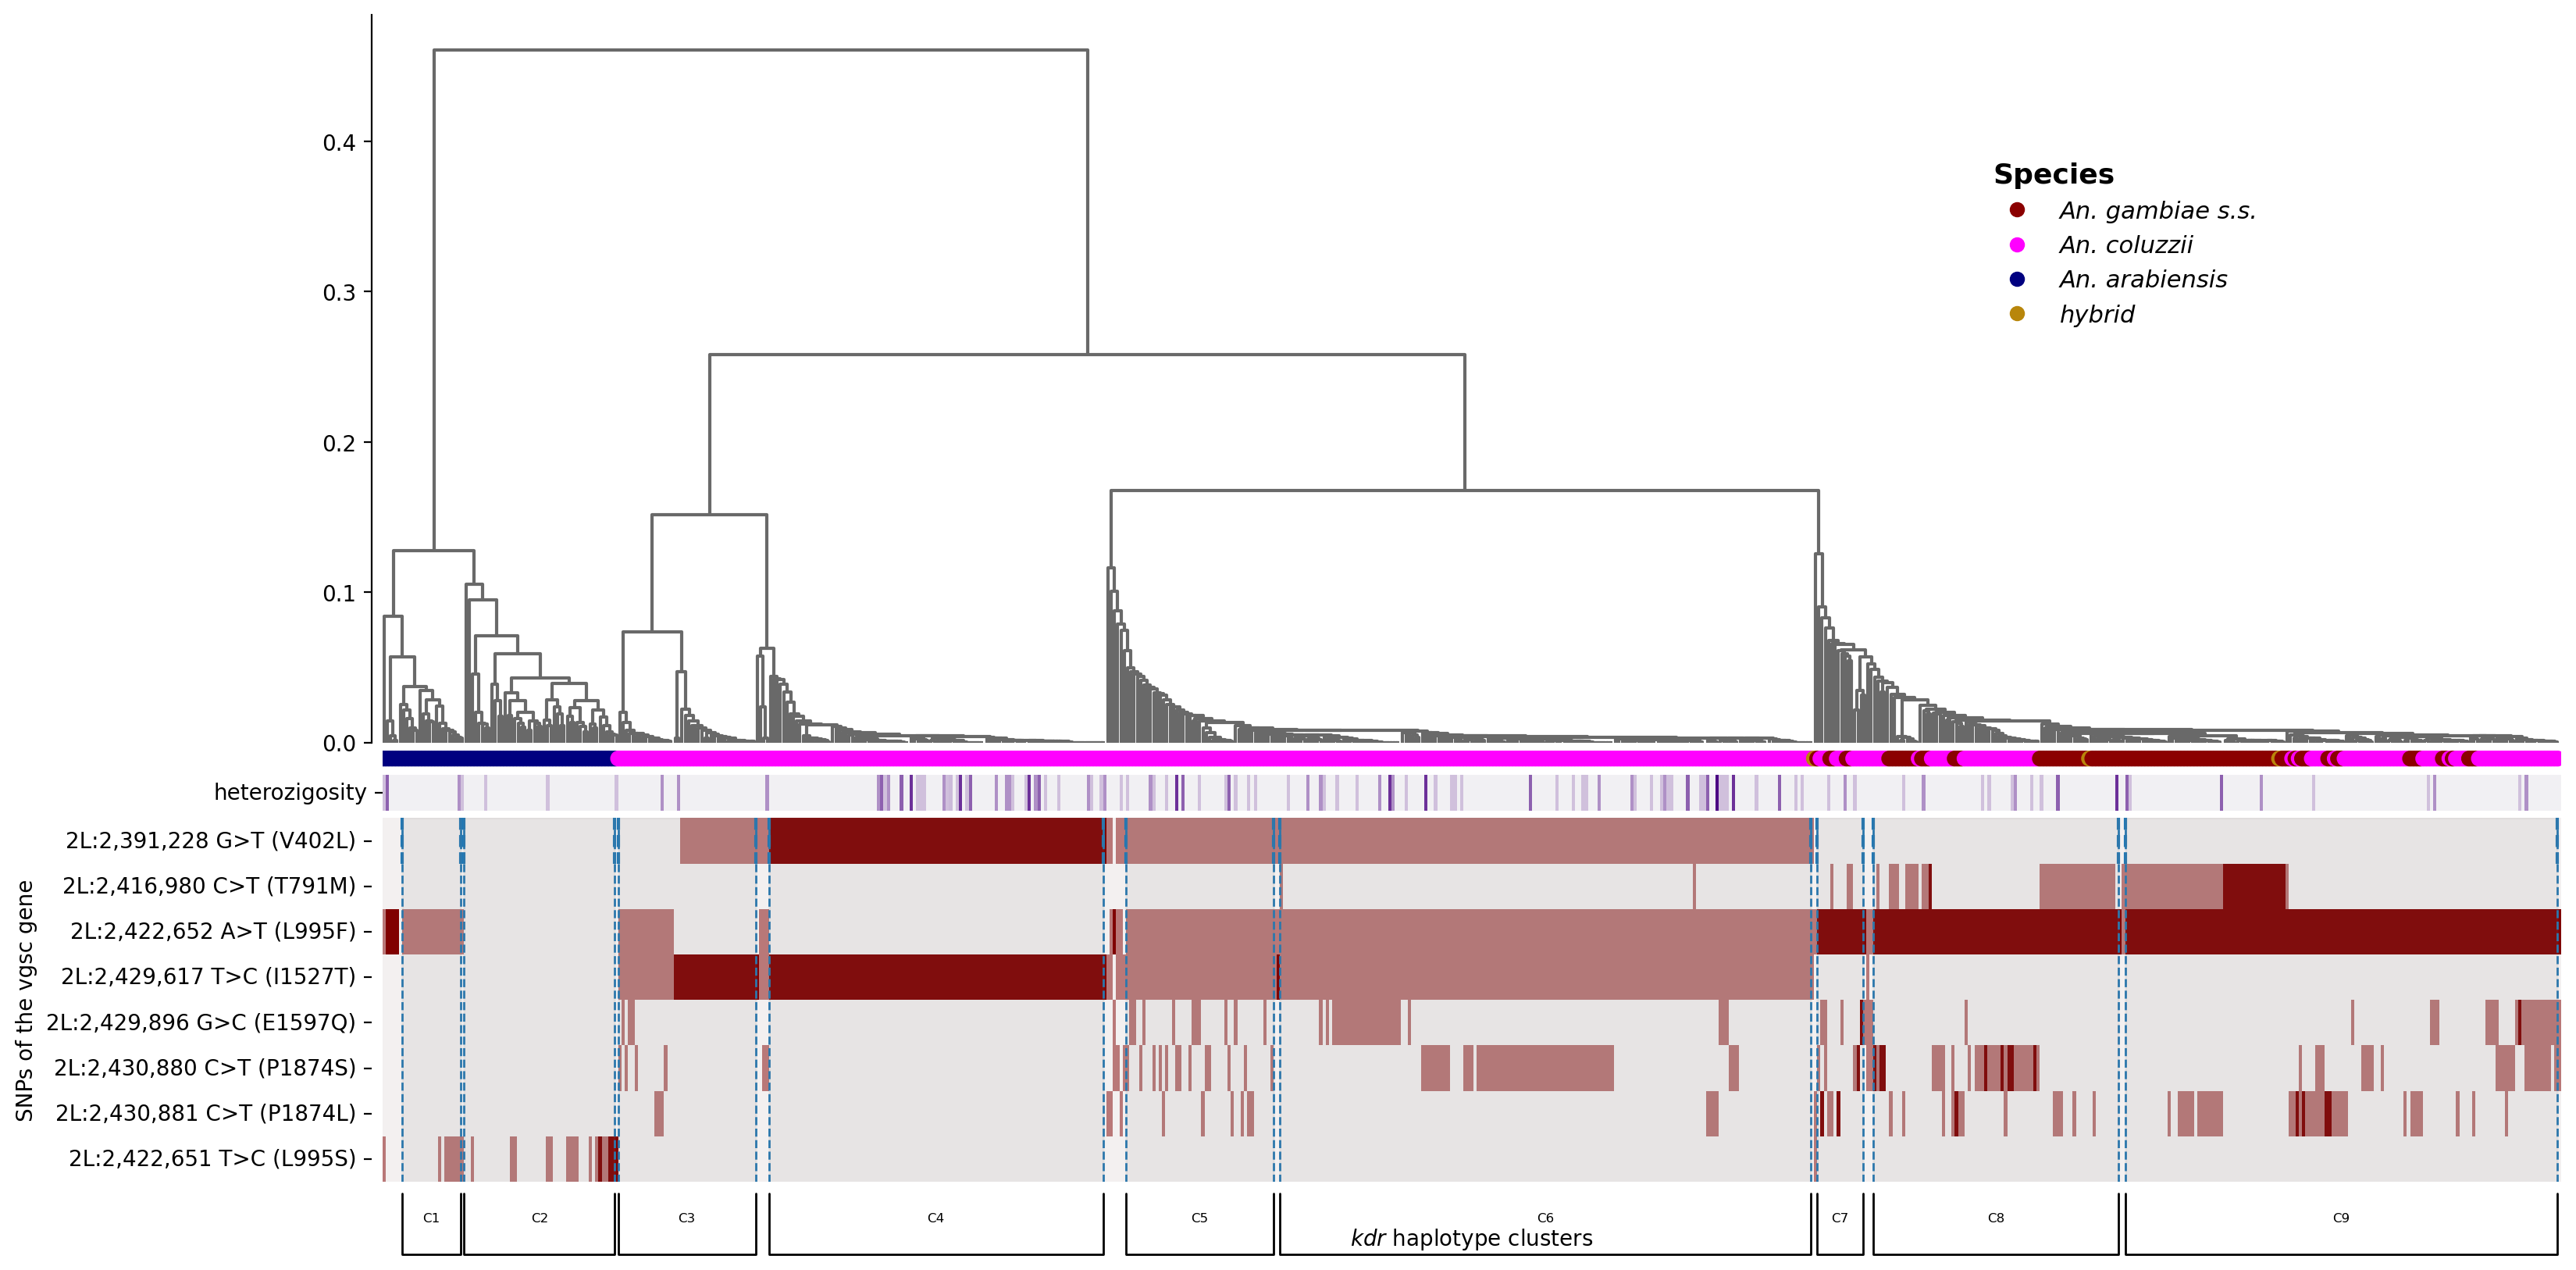

In [35]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(5, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax2=sns.heatmap(data=df_het, cmap=sns.light_palette("indigo", as_cmap=True), xticklabels=[], cbar=False)
ax2.set(xlabel=' ', ylabel=' ')
plt.yticks(rotation=0)

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("maroon", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.8),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
cluster_labels = ['C1', 'C2', 'C3', 'C4', 'C5','C6','C7','C8','C9']
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[4, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
    ax3.vlines([xmin, xmax], 0, 1, linestyle='--')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')

plt.show()
#fig.savefig(fname='VGSC/save_fig/clust_fig.png',dpi=300, bbox_inches='tight')

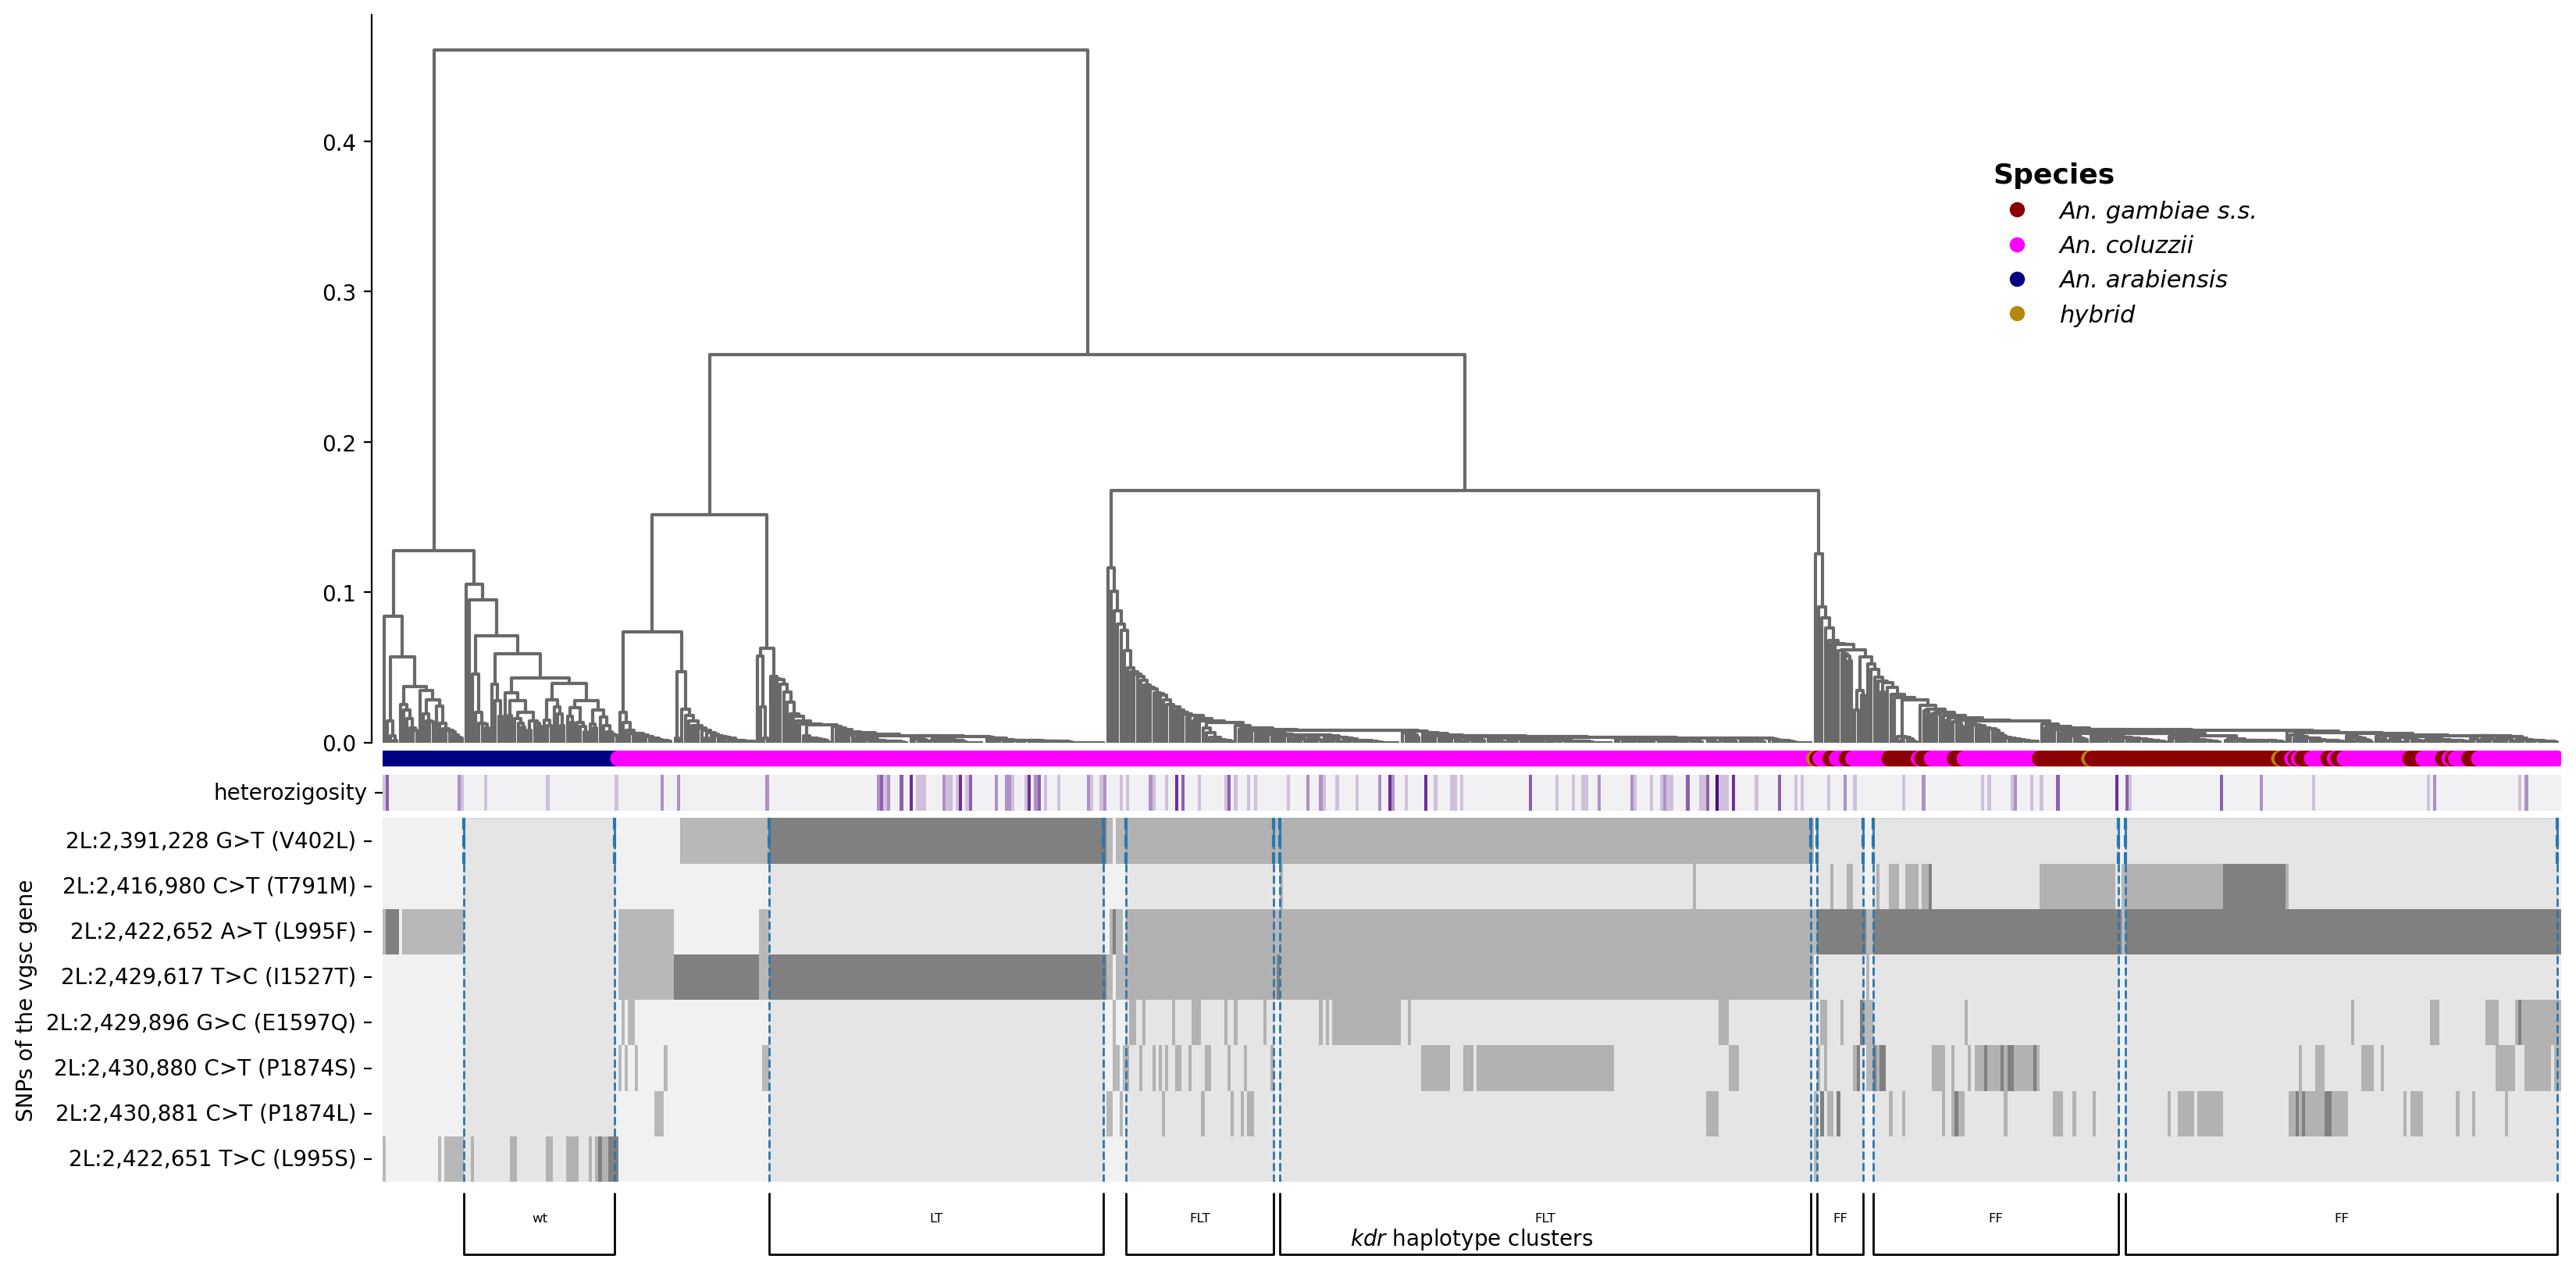

In [36]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(5, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax2=sns.heatmap(data=df_het, cmap=sns.light_palette("indigo", as_cmap=True), xticklabels=[], cbar=False)
ax2.set(xlabel=' ', ylabel=' ')
plt.yticks(rotation=0)

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.8, 0.8),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
cluster_labels = ['', 'wt', '', 'LT', 'FLT','FLT','FF','FF','FF']
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[4, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
    ax3.vlines([xmin, xmax], 0, 1, linestyle='--')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')

plt.show()
fig.savefig(fname='VGSC/save_fig/clust_fig123.png',dpi=300, bbox_inches='tight')

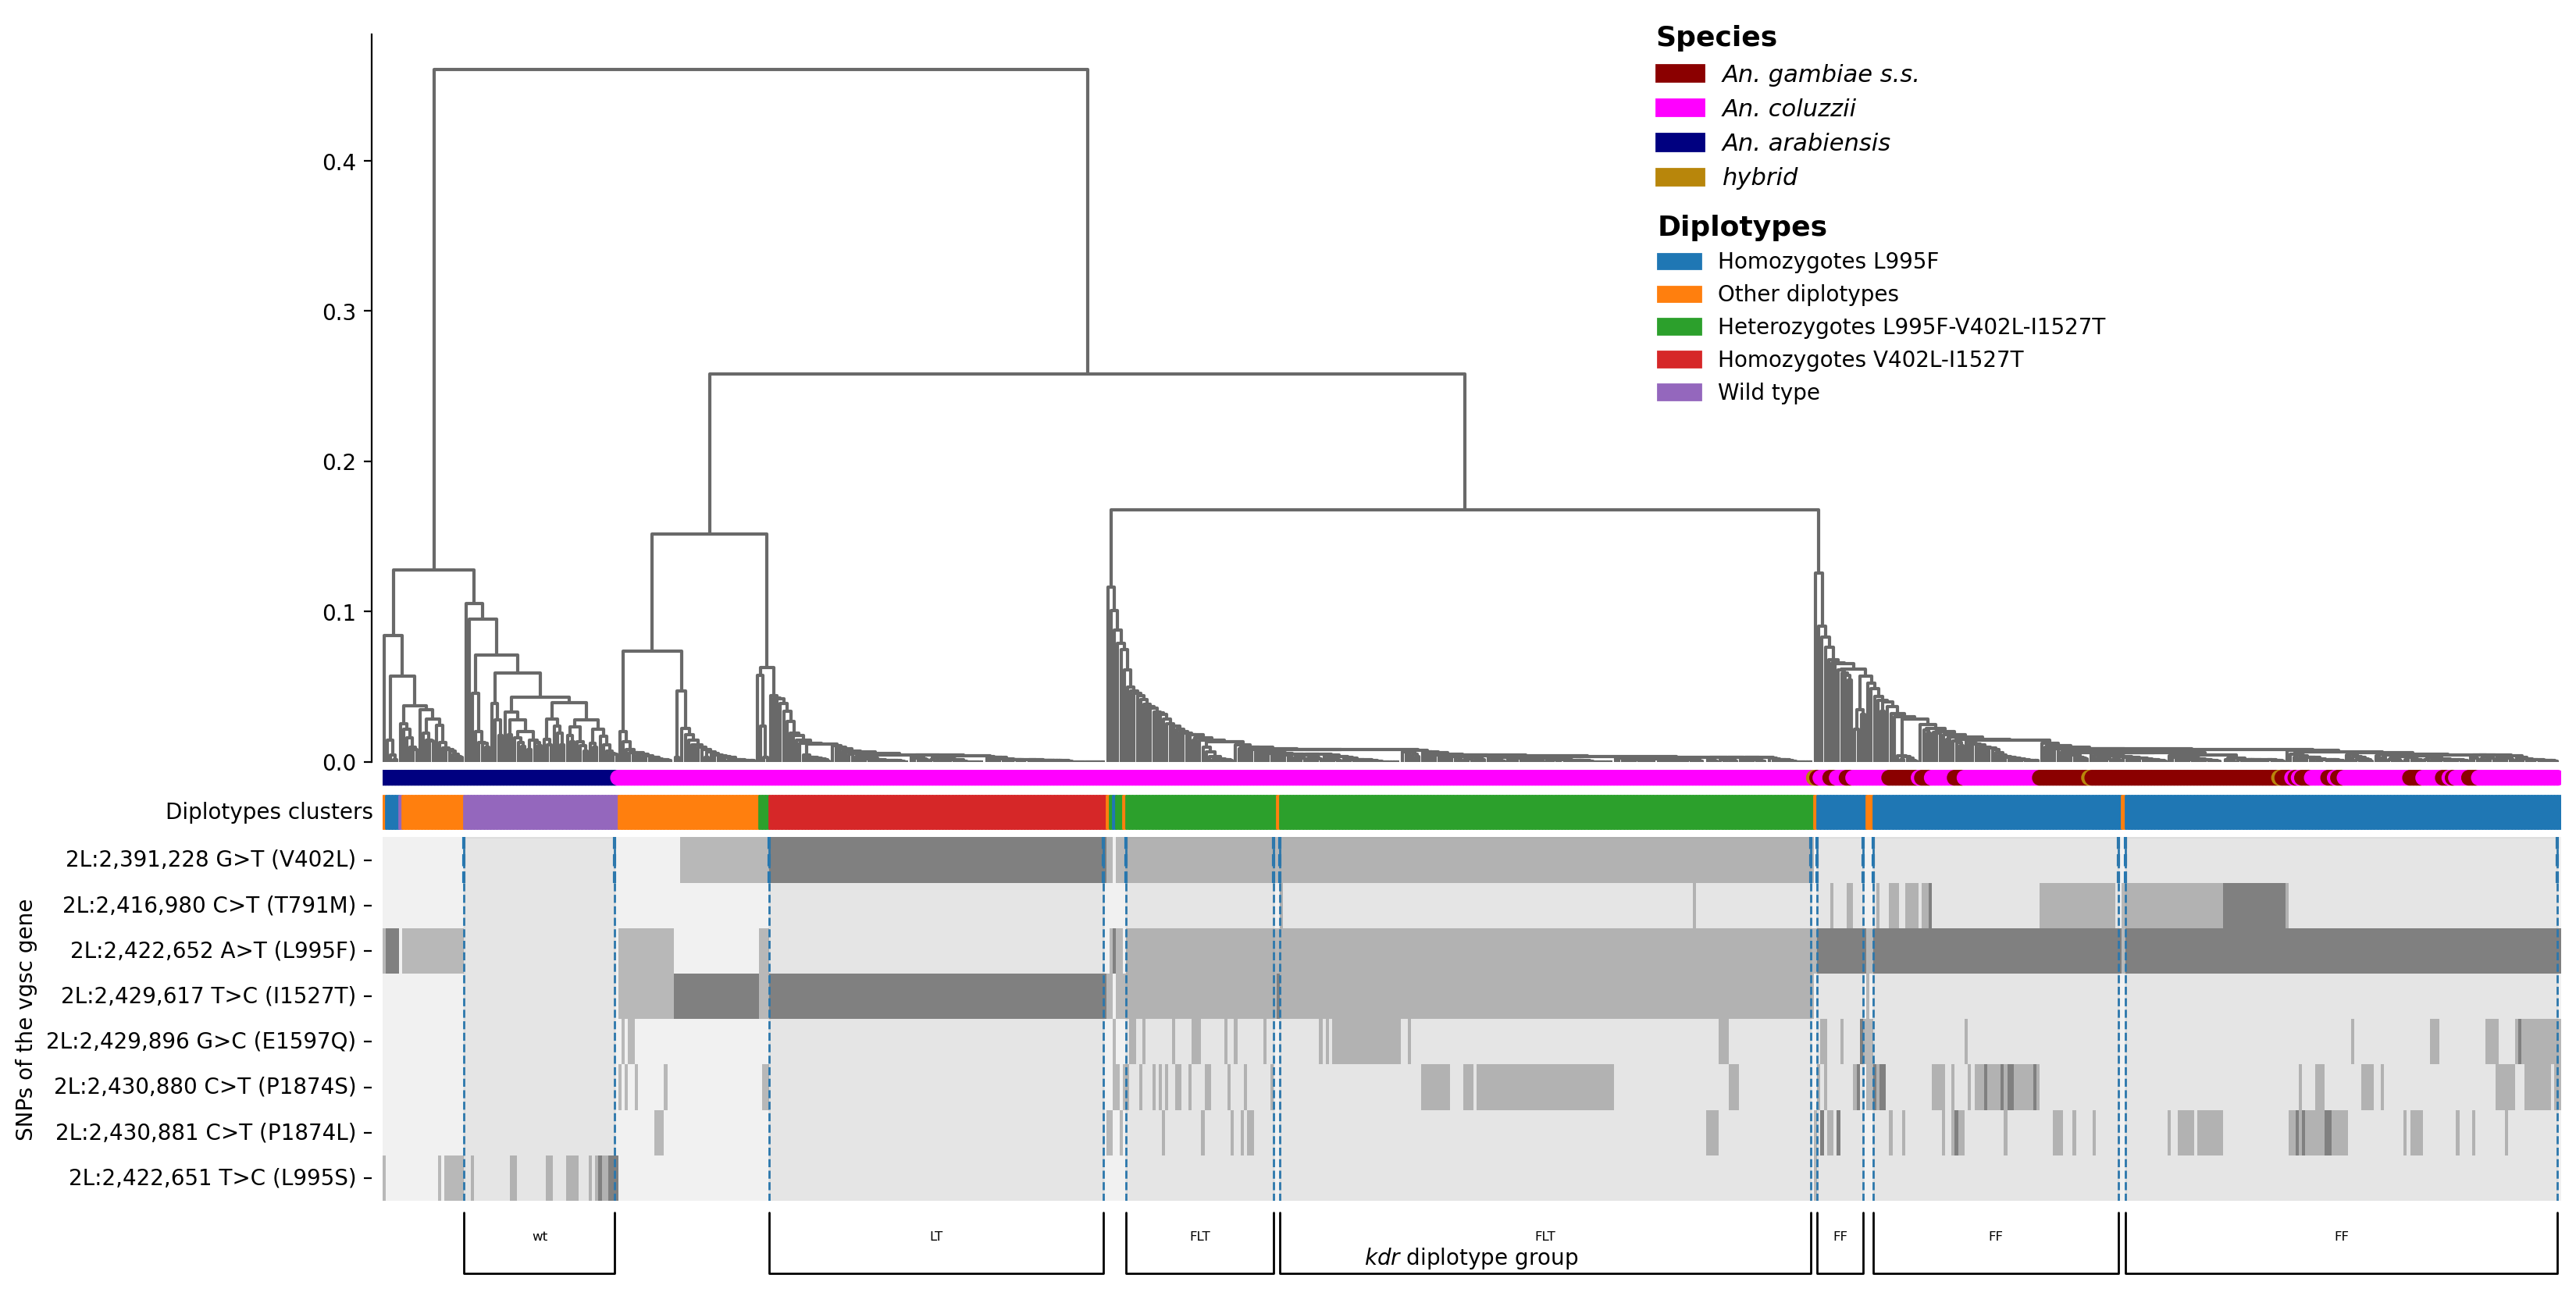

In [37]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(5, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Diplotypes clusters',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
cluster_labels = ['', 'wt', '', 'LT', 'FLT','FLT','FF','FF','FF']
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[4, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
    ax3.vlines([xmin, xmax], 0, 1, linestyle='--')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ diplotype group')

sf = list(ag_dict.keys())
ccmap = dict(zip(sf, sp_col))
handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',
              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.8, 0.78),frameon=False)
ax0.add_artist(aleg)

plt.show()
fig.savefig(fname='VGSC/save_fig/clust_fig12.png',dpi=300, bbox_inches='tight')

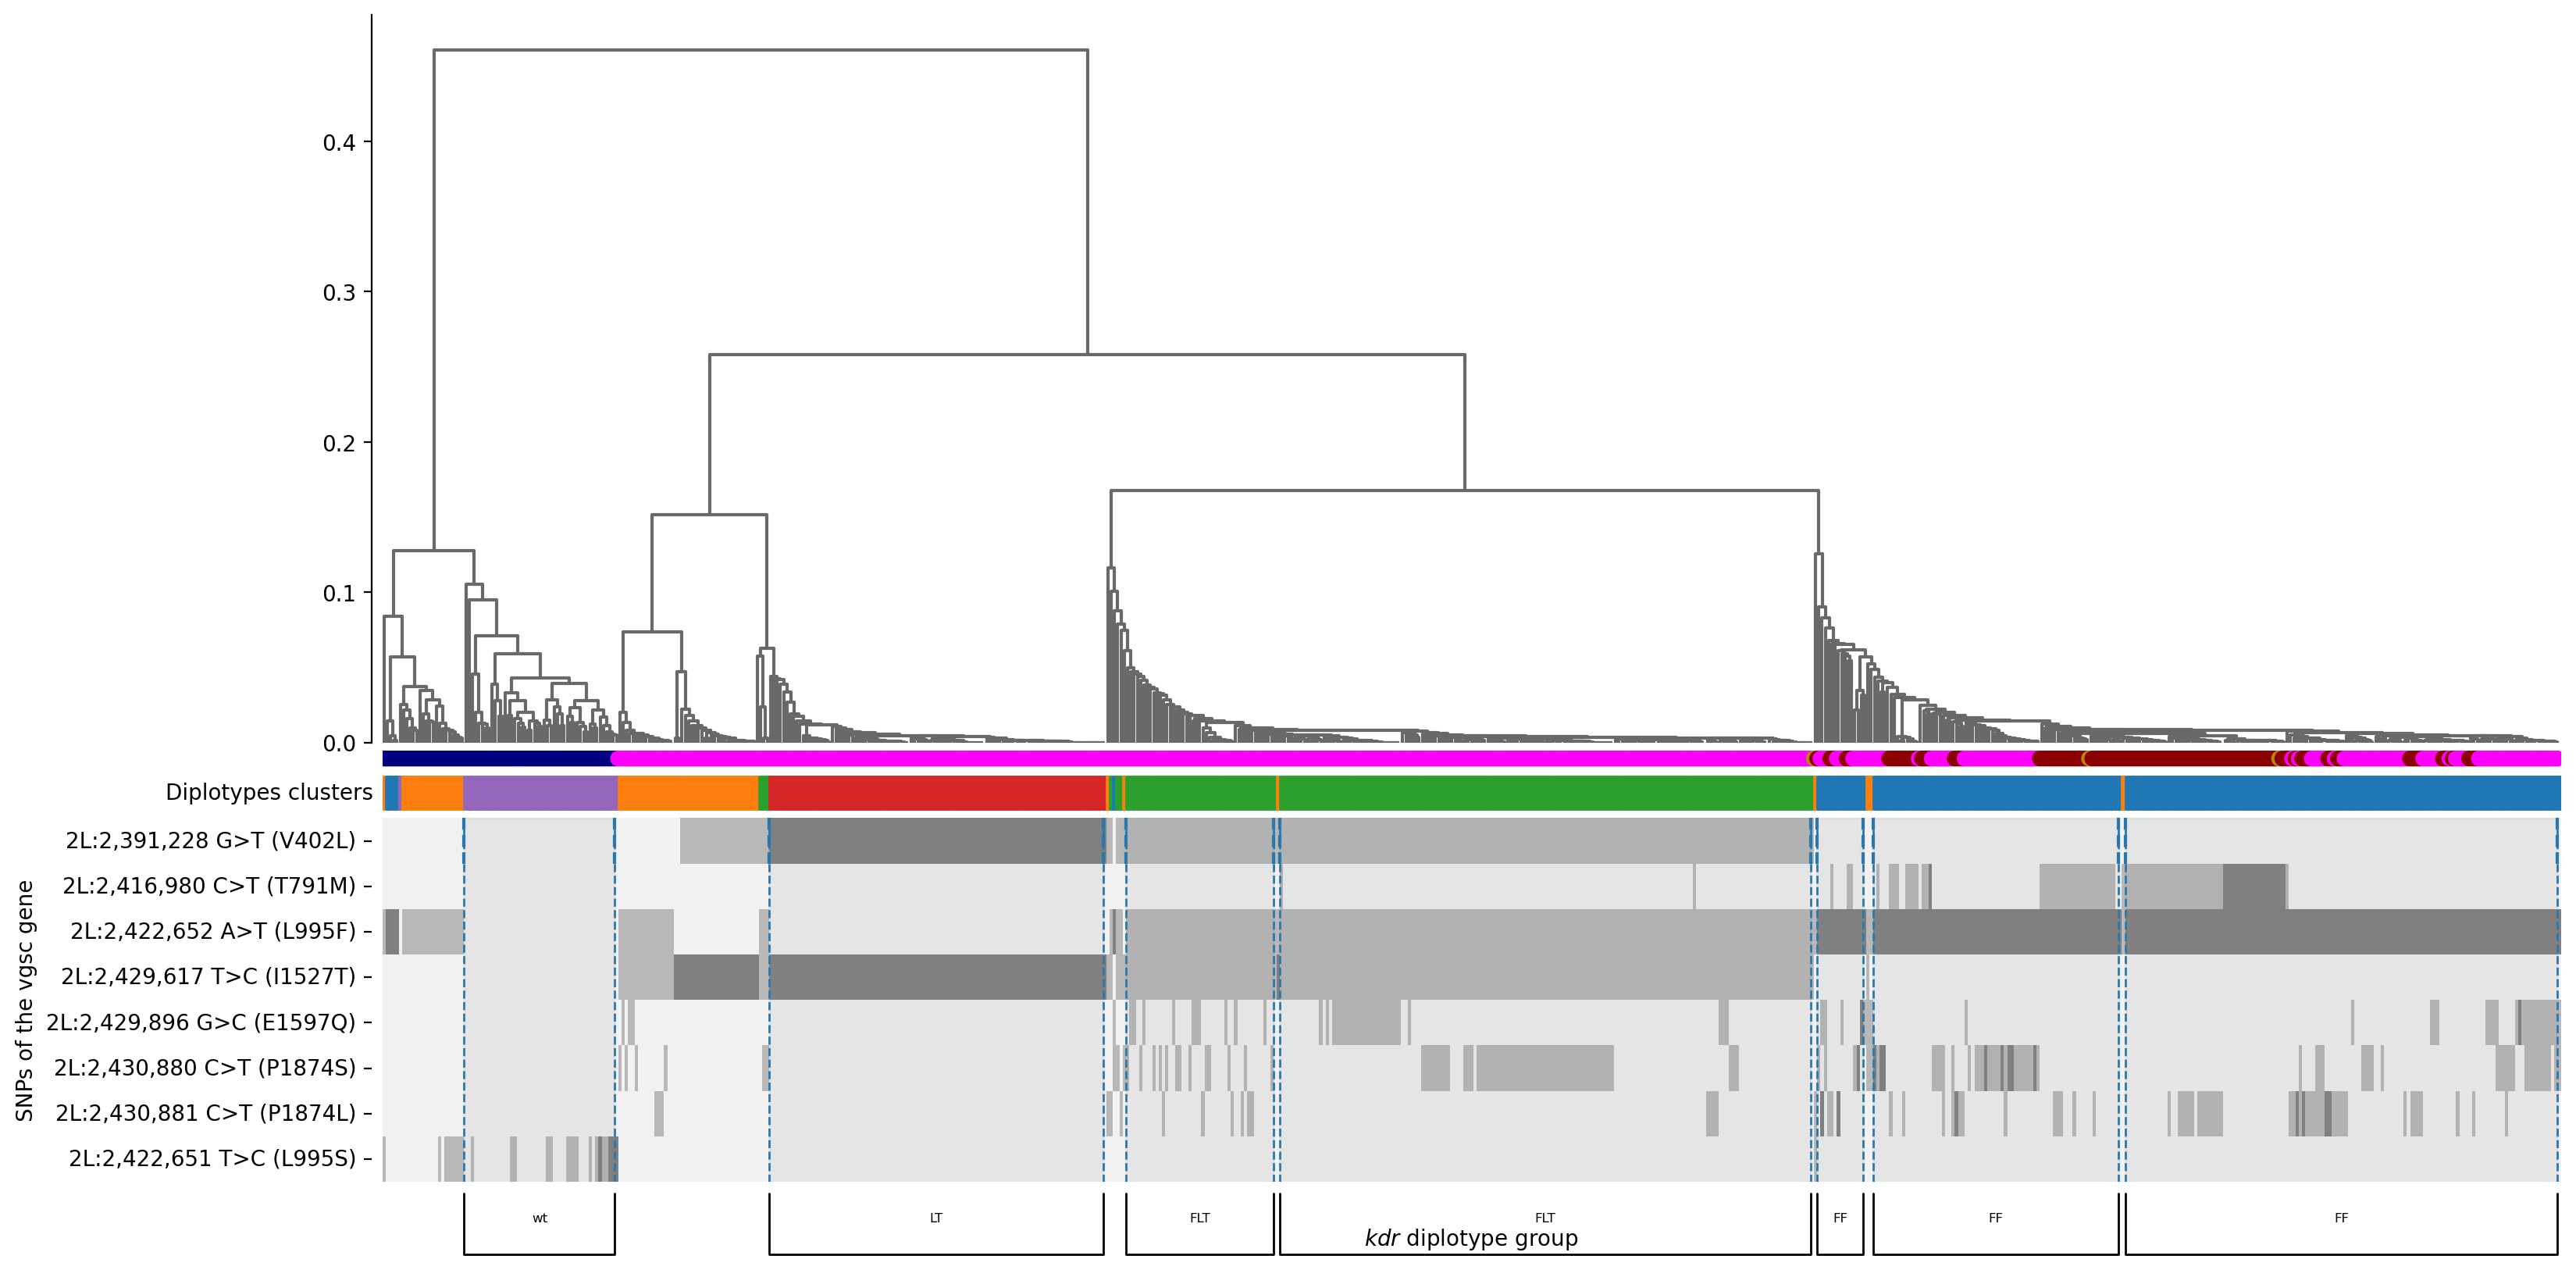

In [39]:
fig = plt.figure(figsize=(18,10))
gs = GridSpec(5, 1, hspace = 0.03, height_ratios=(2,0.05,0.1,1,0.08))

ax0 = fig.add_subplot(gs[0, 0])
sns.despine(ax=ax0, offset=5,bottom=True)
dend = scipy.cluster.hierarchy.dendrogram(z_clust, count_sort=True, ax=ax0, color_threshold=0, no_labels=True,
                                         above_threshold_color='dimgrey')
ax1 = plt.subplot(gs[1, 0])
ax_fig = ax1.scatter(leaf_data.dx, leaf_data.dy, s=40,c=leg_values, cmap=color_maps)
#handles, labels = ax_fig.legend_elements()
plt.xlim(0,n_leaves)
plt.axis('off')

ax2 = plt.subplot(gs[2, 0])
ax_fig1 = ax2.broken_barh(xranges=[(i, 1) for i in range(leaf_data.shape[0])], yrange=(0, 1), color=hap_color)
ax2.set_xlim(0,n_leaves)
sns.despine(ax=ax2, offset=5, left=True, bottom=True)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.yaxis.set_label_position('left')
#plt.axis('off')
ax2.set_ylabel('Diplotypes clusters',rotation=0, ha='right', va='center')

ax3 = plt.subplot(gs[3, 0])
sns.despine(ax=ax3, offset=5,bottom=True)
sns.heatmap(data=dfs_snps, cmap=sns.light_palette("grey", as_cmap=True), xticklabels=[],
            cbar=False, ax=ax3)
ax3.set(xlabel='', ylabel='SNPs of the vgsc gene')

#clustard = find_clusters(z, n=5, threshold=10)
#vspans = [truspan(cluster, dend) for cluster in clustard]
cluster_labels = ['', 'wt', '', 'LT', 'FLT','FLT','FF','FF','FF']
# KDR haplotype clusters
ax_clu = fig.add_subplot(gs[4, 0])
sns.despine(ax=ax_clu, bottom=True, left=True)
ax_clu.set_xlim(0, df_het.shape[1])
ax_clu.set_ylim(0, 1)
for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
  if lbl:
    # hack to get the "fraction" right, which controls length of bracket arms
    fraction = -20 / (xmax - xmin)
    ax_clu.annotate("", ha='left', va='center',xy=(xmin, 1), xycoords='data',xytext=(xmax, 1),
                    textcoords='data',arrowprops=dict(arrowstyle="-",connectionstyle="bar,fraction=%.4f" % fraction,),)
    ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
    ax3.vlines([xmin, xmax], 0, 1, linestyle='--')
    ax3.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), df_het.shape[1],
                                facecolor='gray', edgecolor='gray', alpha=.1,zorder=20))
    ax3.vlines([xmin, xmax], 0, df_het.shape[1], linestyle='--', lw=1)
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ diplotype group')

#sf = list(ag_dict.keys())
#ccmap = dict(zip(sf, sp_col))
#handles = [mpl.patches.Patch(color=v, label=ag_dict[k]) for k, v in ccmap.items()]
#fig.legend(title='Species', labels=leg_labels, handles=handles,bbox_to_anchor=(0.68, 0.9),frameon=False,
#          prop={'size':11, 'style': 'italic'}, title_fontproperties={'size':13, 'weight':'bold'}, alignment='left')

#cmap = dict(zip(haplo_source, haplo_col))
#handles = [patches(color=v, label=k) for k, v in cmap.items()]
#handles = [mpl.patches.Patch(color=v, label=hap_labels[k]) for k, v in cmap.items()]
#aleg = Legend(ax0, handles=handles,labels=haplo_labels, title = 'Diplotypes', alignment='left',
#              title_fontproperties={'size':13, 'weight':'bold'}, bbox_to_anchor=(0.8, 0.78),frameon=False)
#ax0.add_artist(aleg)

plt.show()
fig.savefig(fname='VGSC/save_fig/clust_fig12_legend.png',dpi=300, bbox_inches='tight')